# Proyecto: Estimación de costos de equipo para proyectos de construcción.
## Modelado - Estimación de costos  

**Objetivo:** usar la ventana común de 12 meses (X, Y, Z) para estimar costos base de los equipos, bandas de incertidumbre y sensibilidad.

Para esta parte del proyecto se llevará a cabo el siguiente esquema en código

```mermaid
    graph LR
        A[1 <br> Cargar estadísticos de ventana común 12m]-->B[ 2 <br>Extraer parámetros X, Y, Z]
        B-->C[ 3 <br> Cálculo de costos - Base y Bandas]
        C-->D[ 4 <br> Sensibilidad +/−10% por materia prima]
        D-->E[ 5 <br> Serie mensual de equipos - 12m comunes]
```

### 1. Carga estadísticos de ventana común 12m 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = "C:/Users/nat27/Desktop/Desktop/Proyectos/CienciaDatos/equipment-cost-estimation/data/clean"
OUT_DIR  = Path(DATA_DIR) 


In [2]:
stats_path_try = [
    Path(DATA_DIR) / "stats_12m_common_window.csv"
]
for p in stats_path_try:
    if p.exists():
        stats_path = p
        break
else:
    raise FileNotFoundError("No encuentro stats_12m_common_window.csv en DATA_DIR")

stats = pd.read_csv(stats_path)
stats.columns = [c.strip().lower() for c in stats.columns]
serie_col = "serie" if "serie" in stats.columns else stats.columns[0]
stats = stats.set_index(serie_col)

display(stats)


,mean_12m,std_12m,p25_12m,p75_12m
unnamed: 0,,,,
X,83.45,5.71,79.90,86.39
Y,31650.74,9693.44,24643.06,37640.35
Z,2287.99,108.06,2217.32,2348.60


### 2. Extraer parámetros X, Y, Z

In [5]:
def get(serie, col):
    
    for key in [serie, serie.lower(), serie.upper(), serie.title()]:
        if key in stats.index and col in stats.columns:
            return float(stats.loc[key, col])
    return np.nan

meanX, stdX, p25X, p75X = get("X","mean_12m"), get("X","std_12m"), get("X","p25_12m"), get("X","p75_12m")
meanY, stdY, p25Y, p75Y = get("Y","mean_12m"), get("Y","std_12m"), get("Y","p25_12m"), get("Y","p75_12m")
meanZ, stdZ, p25Z, p75Z = get("Z","mean_12m"), get("Z","std_12m"), get("Z","p25_12m"), get("Z","p75_12m")

meanX, meanY, meanZ


(83.45, 31650.74, 2287.99)

### 3. Cálculo de costos - base y bandas

In [6]:
# Equipo 1
E1_base     = 0.2*meanX + 0.8*meanY
E1_low_std  = 0.2*(meanX - stdX) + 0.8*(meanY - stdY)
E1_high_std = 0.2*(meanX + stdX) + 0.8*(meanY + stdY)
E1_low_pct  = 0.2*p25X + 0.8*p25Y
E1_high_pct = 0.2*p75X + 0.8*p75Y

# Equipo 2
E2_base     = (meanX + meanY + meanZ) / 3.0
E2_low_std  = ((meanX - stdX) + (meanY - stdY) + (meanZ - stdZ)) / 3.0
E2_high_std = ((meanX + stdX) + (meanY + stdY) + (meanZ + stdZ)) / 3.0
E2_low_pct  = (p25X + p25Y + p25Z) / 3.0
E2_high_pct = (p75X + p75Y + p75Z) / 3.0

equip_table = pd.DataFrame({
    "Equipo": ["Equipo 1", "Equipo 2"],
    "Base (media 12m)": [E1_base, E2_base],
    "Bajo (media±σ)":   [E1_low_std, E2_low_std],
    "Alto (media±σ)":   [E1_high_std, E2_high_std],
    "Bajo (P25)":       [E1_low_pct, E2_low_pct],
    "Alto (P75)":       [E1_high_pct, E2_high_pct],
}).round(2)

display(equip_table)

equip_table.to_csv(Path(OUT_DIR) / "equipos_costos_base_bandas.csv", index=False)


,Equipo,Base (media 12m),Bajo (media±σ),Alto (media±σ),Bajo (P25),Alto (P75)
0,Equipo 1,25337.28,17581.39,33093.18,19730.43,30129.56
1,Equipo 2,11340.73,8071.66,14609.80,8980.09,13358.45


### 4. Sensibilidad +/−10% por materia prima

In [7]:
base1, base2 = E1_base, E2_base

def e1(dx=0, dy=0):
    return 0.2*(meanX*(1+dx)) + 0.8*(meanY*(1+dy))

def e2(dx=0, dy=0, dz=0):
    return (meanX*(1+dx) + meanY*(1+dy) + meanZ*(1+dz)) / 3.0

rows = []
shocks = {
    "X +10%": (0.10, 0.00, 0.00),
    "Y +10%": (0.00, 0.10, 0.00),
    "Z +10%": (0.00, 0.00, 0.10),
    "X -10%": (-0.10, 0.00, 0.00),
    "Y -10%": (0.00, -0.10, 0.00),
    "Z -10%": (0.00, 0.00, -0.10),
}

for name, (dx,dy,dz) in shocks.items():
    new1 = e1(dx,dy)
    new2 = e2(dx,dy,dz)
    rows.append({
        "Escenario": name,
        "Equipo 1 (abs)": round(new1, 2),
        "Equipo 1 (Δ%)":  round((new1/base1 - 1)*100, 2) if base1 else np.nan,
        "Equipo 2 (abs)": round(new2, 2),
        "Equipo 2 (Δ%)":  round((new2/base2 - 1)*100, 2) if base2 else np.nan,
    })

sens_table = pd.DataFrame(rows)
display(sens_table)

sens_table.to_csv(Path(OUT_DIR) / "sensibilidad_shocks_10pct.csv", index=False)


,Escenario,Equipo 1 (abs),Equipo 1 (Δ%),Equipo 2 (abs),Equipo 2 (Δ%)
0,X +10%,25338.95,0.01,11343.51,0.02
1,Y +10%,27869.34,9.99,12395.75,9.30
2,Z +10%,25337.28,0.00,11416.99,0.67
3,X -10%,25335.61,-0.01,11337.94,-0.02
4,Y -10%,22805.22,-9.99,10285.70,-9.30
5,Z -10%,25337.28,0.00,11264.46,-0.67


### 5. Serie mensual de equipos - 12m comunes

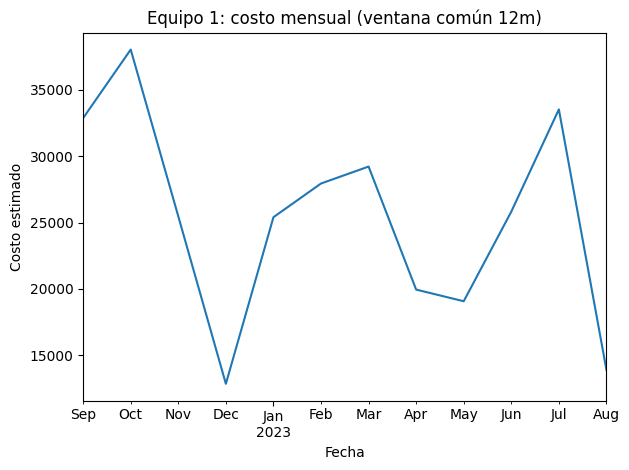

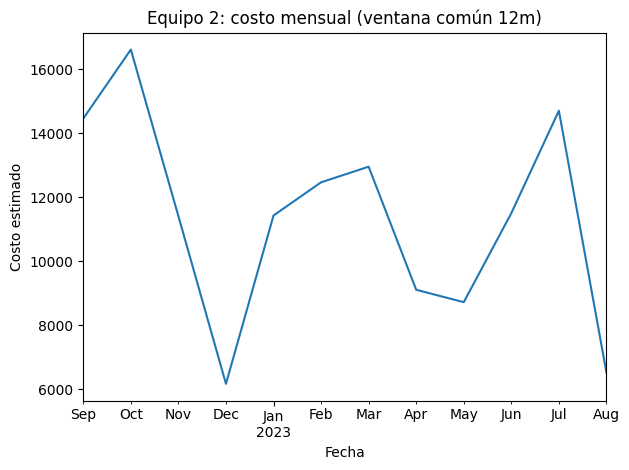

In [8]:
# Cargamos la ventana común mes a mes
win_path_try = [
    Path(DATA_DIR) / "xyz_12m_common_window.csv"
]
for p in win_path_try:
    if p.exists():
        win_path = p
        break
else:
    raise FileNotFoundError("No encuentro xyz_12m_common_window.csv.")

win = pd.read_csv(win_path, parse_dates=["Date"]).set_index("Date").sort_index()

# Cálculo mensual de cada equipo
e1_series = (0.2*win["X"] + 0.8*win["Y"]).dropna()
e2_series = ((win["X"] + win["Y"] + win["Z"]) / 3.0).dropna()

equip_monthly = pd.DataFrame({"Equipo 1": e1_series, "Equipo 2": e2_series})
equip_monthly.to_csv(OUT_DIR / "equipos_mensual_12m.csv")

# Gráficas (una por equipo)
plt.figure()
equip_monthly["Equipo 1"].plot()
plt.title("Equipo 1: costo mensual (ventana común 12m)")
plt.xlabel("Fecha"); plt.ylabel("Costo estimado"); plt.tight_layout(); plt.show()

plt.figure()
equip_monthly["Equipo 2"].plot()
plt.title("Equipo 2: costo mensual (ventana común 12m)")
plt.xlabel("Fecha"); plt.ylabel("Costo estimado"); plt.tight_layout(); plt.show()
